In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
import time
from casadi.tools import *
from scipy import *
#plt.interactive(True)
import pandas as pd

In [2]:
df_actual = pd.read_csv(r'D:\\Subjects\\Semester 4\\NO Project\actual_data.csv')
df_input = pd.read_csv(r'D:\\Subjects\\Semester 4\\NO Project\input_data.csv')
df_meas = pd.read_csv(r'D:\\Subjects\\Semester 4\\NO Project\meas_data.csv')

In [3]:
df_input = DM(np.array(df_input))
df_actual = DM(np.array(df_actual))
df_meas = DM(np.array(df_meas))

In [4]:
N = 10
dt = 0.5
Nsimulation = 332
eps = 0.0001
sigma_delta = 0.05 # Standard deviation of the position measurements
sigma_noise = 0.01 # Standard deviation for the process noise
R = DM(1/sigma_delta**2) # resulting weighting matrix for the position measurements
Q = DM(1/sigma_noise**2) # resulting weighting matrix for the process noise

In [5]:
# The state
states = struct_symSX(["x","y", "theta"]) # Full state vector of the system: position x and position y and angle theta
Nstates = states.size # Number of states
x, y, theta = states[...]

# The control input
controls = struct_symSX(["delta_trans", "delta_r1", "delta_r2"]) # Full control vector of the system
Ncontrols = controls.size # Number of control inputs
delta_r1, delta_r2, delta_trans = controls[...]

# Measurements
measurements = struct_symSX(["xm", "ym", "thetam"]) # Measurement vector
Nmeas = measurements.size # Number of measurements
xm, ym, thetam = measurements[...]

In [6]:
# Create Structure for the entire horizon

# Decision variables
dec_var = struct_symSX([(entry("X",repeat=N,struct=states))])
# Input for optimizer
parameters = struct_symSX([(entry("U",repeat=N-1,struct=controls),entry("Y",repeat=N,struct=measurements),entry("x0",shape=(Nstates,1)))])
x0 = parameters["x0"]
# ODE right hand side
rhs = struct_SX(states)
rhs["x"] = delta_trans*np.cos(theta + delta_r1)
rhs["y"] = delta_trans*np.sin(theta+delta_r1)
rhs["theta"] = delta_r1+delta_r2

f = Function('f', [states,controls],[rhs])

In [7]:
#Runge Kutta 4 integrator
k1 = f(states,controls)
k2 = f(states+dt/2.0*k1,controls)
k3 = f(states+dt/2.0*k2,controls)
k4 = f(states+dt*k3,controls)

states_1 = states+dt/6.0*(k1+2*k2+2*k3+k4)
phi = Function('phi', [states,controls],[states_1])

#Measurement model
r = np.sqrt(x**2+y**2) 
alpha = np.arctan(y /(x + eps))

xm = r*np.cos(alpha) 
ym= r*np.sin(alpha)
thetam = theta
h = Function('h', [states],[xm,ym,thetam])
#Objective
obj = 0
#Next the cost for the measurement noise
for i in range(N):
    vm = vertcat(*h(dec_var["X",i]))-parameters["Y",i]
    obj += mtimes([vm.T,R,vm])

In [8]:
# Build the multiple shooting constraints
g = []
for i in range(N-1):
  g.append( dec_var["X",i+1] - phi(dec_var["X",i],parameters["U",i]) )
g=vertcat(*g)

In [9]:
# Formulate the NLP    
nlp = {'x':dec_var, 'p':parameters, 'f':obj,'g':g} 

In [12]:
# Make a simulation to create the data for the problem
simulated_X = DM.zeros(Nstates,Nsimulation)
simulated_X[:,0] = DM([0,0,0]) # Initial state
simulated_U = df_input.T # control input for the simulation
for i in range(Nsimulation-1):
  simulated_X[:,i+1] = simulated_X[:,i] + f(simulated_X[:,i], simulated_U[:,i])
#Create the measurements from these states
simulated_Y = DM.zeros(Nmeas,Nsimulation) # Holder for the measurements
for i in range(Nsimulation-1):
   simulated_Y[:,i] = vertcat(*h(simulated_X[:,i]))
#Add noise the the position measurements
simulated_Y += sigma_delta*np.random.randn(simulated_Y.shape[0],simulated_Y.shape[1])

In [13]:
simulated_Y.shape

(3, 332)

In [14]:
plt.plot(vec(simulated_Y[0,:]),vec(simulated_Y[1,:]))
plt.plot(vec(simulated_X[0,:]),vec(simulated_X[1,:]))
plt.title("Trajectories")
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend(['Measured trajectory','Actual trajectory'], bbox_to_anchor=(1,1))
plt.grid()

In [15]:
plt.plot(vec(simulated_X[0,:])-vec(simulated_Y[0,:]))

In [16]:
#Initial value
x0 = simulated_X[:,0]
# Create the solver
nlpsol = nlpsol("nlpsol", "ipopt", nlp)

In [17]:
df_input.shape

(332, 3)

In [18]:
# Create a holder for the estimated states and disturbances
estimated_X= DM.zeros(Nstates,Nsimulation)
# For the first instance we run the filter, we need to initialize it.
current_parameters = parameters(0)
current_parameters["U",lambda x: horzcat(*x)] = df_input.T[:,0:N-1]
current_parameters["Y",lambda x: horzcat(*x)] = simulated_Y[:,0:N]
#current_parameters["S"] = linalg.inv(P) # Arrival cost is the inverse of the initial covariance
current_parameters["x0"] = x0
initialisation_state = dec_var(0)
initialisation_state["X",lambda x: horzcat(*x)] = simulated_X[:,0:N]
res = nlpsol(p=current_parameters, x0=initialisation_state, lbg=0, ubg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       72
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       40

Error evaluating objective gradient at user provided starting point.
  No scaling factor for objective function computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 1
Number of 

CasADi -  WARNING("nlpsol:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("nlpsol:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


In [19]:
# Get the solution
solution = dec_var(res["x"])
estimated_X[:,0:N] = solution["X",lambda x: horzcat(*x)]

In [20]:
estimated_X.shape

(3, 332)

In [21]:
# Now make a loop for the rest of the simulation
for i in range(1,Nsimulation-N+1):
  # Input deltas and measurements
  current_parameters["U",lambda x: horzcat(*x)] = df_input.T[:,i:i+N-1]
  current_parameters["Y",lambda x: horzcat(*x)] = simulated_Y[:,i:i+N]
  #current_parameters["S"] = linalg.inv(P)
  current_parameters["x0"] = x0
  # Initialize the system according to horizon
  initialisation_state["X",lambda x: horzcat(*x),0:N-1] = estimated_X[:,i:i+N-1] # The shifted solution for the state estimates
  # The last node for the state is initialized with a forward simulation
  phi0 = phi(initialisation_state["X",N-1], current_parameters["U",-1])
  initialisation_state["X",N-1] = phi0
  # And now initialize the solver and solve the problem
  res = nlpsol(p=current_parameters, x0=initialisation_state,lbg=0)
  solution = dec_var(res["x"])
    # Now get the state estimate. Note that we are only interested in the last node of the horizon
  estimated_X[:,N-1+i] = solution["X",N-1]

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       27
        inequality constraints with only lower bounds:       27
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   3 9.5047233e+000 0.00e+000 2.07e-004  -1.0 3.52e-002    -  1.00e+000 1.00e+000f  1
   4 7.1245001e+000 0.00e+000 7.36e-004  -1.7 1.55e-002    -  1.00e+000 1.00e+000f  1
   5 5.9672220e+000 0.00e+000 2.27e-001  -2.5 9.77e-003    -  9.27e-001 1.00e+000f  1
   6 5.7064282e+000 0.00e+000 5.21e-005  -2.5 4.12e-003    -  1.00e+000 1.00e+000f  1
   7 5.5570998e+000 0.00e+000 1.53e-002  -3.8 2.95e-003    -  9.83e-001 1.00e+000f  1
   8 5.5394909e+000 0.00e+000 4.58e-006  -3.8 1.09e-003    -  1.00e+000 1.00e+000f  1
   9 5.5300930e+000 0.00e+000 3.50e-003  -5.7 5.43e-004    -  9.78e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.5295771e+000 0.00e+000 3.44e-008  -5.7 3.77e-004    -  1.00e+000 1.00e+000h  1
  11 5.5295236e+000 0.00e+000 7.32e-009  -5.7 1.83e-004    -  1.00e+000 1.00e+000h  1
  12 5.5294121e+000 0.00e+000 2.97e-004  -8.6 1.02e-004    -  9.80e-001 1.00e+000h  1
  13 5.5294073e+000 0.00e+000 4.29e-010  -8.6 4.44e-005    

       nlp_g  |        0 (       0)        0 (       0)        11
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        12
  nlp_hess_l  |        0 (       0)        0 (       0)        10
   nlp_jac_g  |        0 (       0)        0 (       0)        12
       total  |  10.00ms ( 10.00ms)   9.96ms (  9.96ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number

Total number of inequality constraints...............:       27
        inequality constraints with only lower bounds:       27
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.5354903e+003 1.79e+000 6.24e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.2805087e+002 1.12e+000 4.01e+001  -1.0 1.92e+000    -  1.00e+000 3.58e-001f  1
   2 3.1996911e+001 4.77e-002 4.00e+000  -1.0 1.21e+000    -  1.00e+000 9.00e-001f  1
   3 3.0788195e+001 0.00e+000 1.35e-004  -1.0 1.29e-001    -  1.00e+000 1.00e+000f  1
   4 1.8627816e+001 0.00e+000 4.90e-001  -2.5 3.92e-002    -  8.85e-001 1.00e+000f  1
   5 1.5364318e+001 0.00e+000 2.30e-001  -2.5 1.60e-002    -  8.88e-001 1.00e+000f  1
   6 1.4369288e+001 0.00e+000 1.11e-005  -2.5 1.37e-002    -  1.00e+000 1.00e+000f  1
   7 1.3700161e+001 0.00e+000 5.42e-002  -3.8 6.05e-003    -

   1 6.5110865e+002 1.20e+000 3.03e+001  -1.0 2.63e+000    -  1.00e+000 5.14e-001f  1
   2 8.1327316e+001 3.39e-001 9.41e+000  -1.0 1.26e+000    -  1.00e+000 6.89e-001f  1
   3 4.2703354e+001 0.00e+000 2.34e-003  -1.0 3.91e-001    -  1.00e+000 1.00e+000f  1
   4 2.4983804e+001 0.00e+000 4.41e-001  -2.5 4.40e-002    -  8.80e-001 1.00e+000f  1
   5 2.0663384e+001 0.00e+000 1.84e-004  -2.5 1.72e-002    -  1.00e+000 1.00e+000f  1
   6 1.9072310e+001 0.00e+000 1.55e-001  -3.8 9.46e-003    -  8.23e-001 1.00e+000f  1
   7 1.8729840e+001 0.00e+000 5.43e-006  -3.8 8.35e-003    -  1.00e+000 1.00e+000f  1
   8 1.8622379e+001 0.00e+000 1.82e-002  -5.7 2.56e-003    -  7.92e-001 1.00e+000f  1
   9 1.8612746e+001 0.00e+000 5.07e-009  -5.7 7.19e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.8611349e+001 0.00e+000 1.37e-005  -8.6 1.36e-004    -  9.95e-001 1.00e+000f  1
  11 1.8611338e+001 0.00e+000 5.13e-014  -8.6 2.64e-006    

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       27
        inequality constraints with only lower bounds:       27
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.4487519e+003 3.21e+000 6.24e+001  -1.0 0.00e+000    -  0.00e+00

  15 9.1903188e+000 0.00e+000 6.88e-014  -9.0 9.68e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  3.1882171190069220e-001   9.1903188236307134e+000
Dual infeasibility......:  6.8833827526759706e-014   1.9841961736243855e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  4.0284645576800235e-009   1.1612406643844860e-007
Overall NLP error.......:  4.0284645576800235e-009   1.1612406643844860e-007


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 16
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 16
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPO

  12 1.7094002e+001 0.00e+000 9.19e-013  -8.6 2.78e-005    -  1.00e+000 1.00e+000h  1
  13 1.7094001e+001 0.00e+000 3.52e-014  -9.0 6.38e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  5.3163550383993308e-001   1.7094000839904115e+001
Dual infeasibility......:  3.5198522307650343e-014   1.1317595712560161e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.1415325375199499e-010   2.9393327523405175e-008
Overall NLP error.......:  9.1415325375199499e-010   2.9393327523405175e-008


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluation

   8 9.8243567e+000 0.00e+000 8.88e-004  -5.7 2.76e-003    -  9.80e-001 1.00e+000f  1
   9 9.8194292e+000 0.00e+000 3.57e-009  -5.7 1.35e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 9.8187240e+000 0.00e+000 1.37e-010  -5.7 5.91e-004    -  1.00e+000 1.00e+000f  1
  11 9.8177999e+000 0.00e+000 3.22e-006  -8.6 2.49e-004    -  9.99e-001 1.00e+000f  1
  12 9.8177950e+000 0.00e+000 8.81e-013  -8.6 4.04e-005    -  1.00e+000 1.00e+000h  1
  13 9.8177943e+000 0.00e+000 5.14e-014  -9.0 1.22e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.7582977129234937e-001   9.8177942686421922e+000
Dual infeasibility......:  5.1362289305553527e-014   1.8281724529073420e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.2580686925494182e-010   3.295286557449590

   nlp_jac_g  |        0 (       0)        0 (       0)        14
       total  |   5.00ms (  5.00ms)   5.00ms (  5.00ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       27
        inequality constraints with only lower bounds:       27
   inequality constraints with lower and upper bounds:        0
        inequality c

   8 2.4538608e+001 0.00e+000 4.47e-009  -5.7 1.31e-003    -  1.00e+000 1.00e+000f  1
   9 2.4538092e+001 0.00e+000 8.12e-011  -5.7 4.48e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4536926e+001 0.00e+000 3.03e-010  -8.6 9.78e-005    -  1.00e+000 1.00e+000f  1
  11 2.4536925e+001 0.00e+000 5.02e-014  -8.6 3.24e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  6.6429913760233050e-001   2.4536925138050012e+001
Dual infeasibility......:  5.0237196055056504e-014   1.8555892202382687e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6578914034109465e-009   9.8173366031978252e-008
Overall NLP error.......:  2.6578914034109465e-009   9.8173366031978252e-008


Number of objective function evaluations             = 12
Number of objective gradient


                                   (scaled)                 (unscaled)
Objective...............:  5.3361085761760085e-001   1.9342917017483114e+001
Dual infeasibility......:  5.7454041524351851e-014   2.0826576926981748e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5111647116600319e-009   9.1027478060951934e-008
Overall NLP error.......:  2.5111647116600319e-009   9.1027478060951934e-008


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 11
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations           =      0.000

EXIT

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       27
        inequality constraints with only lower bounds:       27
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0912945e+003 4.38e+000 6.20e+001  -1.0 0.00e+000    -  0.00e+00

  11 1.1735671e+001 0.00e+000 8.08e-014  -8.6 3.48e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  3.4848901263970172e-001   1.1735670562953604e+001
Dual infeasibility......:  8.0824236192711396e-014   2.7218264423179445e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5073350544707530e-009   8.4436688454899676e-008
Overall NLP error.......:  2.5073350544707530e-009   8.4436688454899676e-008


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 12
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 12
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPO

  11 3.3600185e+001 0.00e+000 2.69e-011  -8.6 3.14e-005    -  1.00e+000 1.00e+000f  1
  12 3.3600184e+001 0.00e+000 7.15e-014  -9.0 1.98e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  1.1601542213130365e+000   3.3600183528569829e+001
Dual infeasibility......:  7.1498362785860081e-014   2.0707230706605811e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0963587737636489e-010   2.6344715092641675e-008
Overall NLP error.......:  9.0963587737636489e-010   2.6344715092641675e-008


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluation

   5 7.1709618e+001 0.00e+000 5.01e-002  -2.5 2.98e-002    -  9.63e-001 1.00e+000f  1
   6 6.9932466e+001 0.00e+000 1.09e-005  -2.5 1.12e-002    -  1.00e+000 1.00e+000f  1
   7 6.8396279e+001 0.00e+000 9.20e-003  -3.8 6.89e-003    -  9.49e-001 1.00e+000f  1
   8 6.8325937e+001 0.00e+000 1.21e-007  -3.8 3.05e-003    -  1.00e+000 1.00e+000f  1
   9 6.8238010e+001 0.00e+000 2.91e-005  -5.7 1.56e-003    -  9.99e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.8237461e+001 0.00e+000 1.10e-010  -5.7 2.72e-004    -  1.00e+000 1.00e+000h  1
  11 6.8236413e+001 0.00e+000 2.07e-011  -8.6 2.16e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  2.6395195299342760e+000   6.8236412778631120e+001
Dual infeasibility......:  2.0663026845113563e-011   5.3417707771012907e-010
Constraint violation....:  0.0000000000000000e+000   0.000000

Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.010
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        13
       nlp_g  |        0 (       0)        0 (       0)        13
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        14
  nlp_hess_l  |        0 (       0)        0 (       0)        12
   nlp_jac_g  |        0 (       0)        0 (       0)        14
       total  |  10.00ms ( 10.00ms)   9.99ms (  9.99ms)         1
This is Ipopt version

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0437703e+002 0.00e+000 1.34e-009  -5.7 2.97e-004    -  1.00e+000 1.00e+000f  1
  11 1.0437591e+002 0.00e+000 9.64e-007  -8.6 4.50e-005    -  1.00e+000 1.00e+000f  1
  12 1.0437591e+002 0.00e+000 9.19e-014  -8.6 7.96e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  4.9806510703397873e+000   1.0437590694325496e+002
Dual infeasibility......:  9.1926466438962962e-014   1.9264365584238507e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5552766895302303e-009   5.3549087899161065e-008
Overall NLP error.......:  2.5552766895302303e-009   5.3549087899161065e-008


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 0

Overall NLP error.......:  5.4147570824487415e-009   9.2324230583923921e-008


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.010
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Optimal Solution Found.
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        13
       nlp_g  |        0 (       0)        0 (       0)        13
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        14
  nlp_hess_l  |   2.00ms

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.1157016e+003 1.42e+000 6.56e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.2995602e+003 1.21e+000 5.63e+001  -1.0 1.85e+000    -  1.00e+000 1.41e-001f  1
   2 1.5179527e+002 1.72e-001 9.20e+000  -1.0 1.59e+000    -  1.00e+000 8.37e-001f  1
   3 1.3788775e+002 1.02e-001 7.08e+000  -1.0 2.15e-001    -  1.00e+000 3.33e-001f  1
   4 1.4627615e+002 0.00e+000 4.47e-003  -1.0 1.43e-001    -  1.00e+000 1.00e+000h  1
   5 1.2369359e+002 0.00e+000 1.71e-003  -2.5 3.51e-002    -  1.00e+000 1.00e+000f  1
   6 1.1976682e+002 0.00e+000 6.07e-005  -3.8 1.62e-002    -  1.00e+000 1.00e+000f  1
   7 1.1915601e+002 0.00e+000 9.30e-002  -3.8 7.23e-003    -  8.82e-001 1.00e+000f  1
   8 1.1904346e+002 0.00e+000 7.05e-008  -3.8 3.18e-003    -  1.00e+000 1.00e+000f  1
   9 1.1898037e+002 0.00e+000 1.61e-003  -5.7 1.34e-003    -  9.85e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   8 8.7947003e+001 0.00e+000 7.18e-007  -3.8 3.13e-003    -  1.00e+000 1.00e+000f  1
   9 8.7831295e+001 0.00e+000 6.36e-004  -5.7 8.86e-004    -  9.91e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.7828574e+001 0.00e+000 1.15e-010  -5.7 4.67e-005    -  1.00e+000 1.00e+000h  1
  11 8.7827493e+001 0.00e+000 6.93e-012  -8.6 6.30e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  3.7702506114715169e+000   8.7827492941849144e+001
Dual infeasibility......:  6.9313443873397773e-012   1.6146475738359785e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.8052741244827616e-009   8.8643361078687211e-008
Overall NLP error.......:  3.8052741244827616e-009   8.8643361078687211e-008


Number of objective function evaluations             = 12
Number of objective gradient

   3 4.9373846e+002 5.63e-003 6.89e+000  -1.0 7.18e-001    -  1.00e+000 4.66e-001f  1
   4 4.6970880e+002 0.00e+000 6.56e-001  -1.0 3.66e-001    -  1.00e+000 9.05e-001f  1
   5 4.2820132e+002 0.00e+000 6.29e-004  -1.7 3.38e-002    -  1.00e+000 1.00e+000f  1
   6 4.1257018e+002 0.00e+000 1.33e-004  -2.5 2.11e-002    -  1.00e+000 1.00e+000f  1
   7 4.0949076e+002 0.00e+000 6.18e-006  -3.8 8.43e-003    -  1.00e+000 1.00e+000f  1
   8 4.0937153e+002 0.00e+000 2.95e-008  -3.8 1.45e-003    -  1.00e+000 1.00e+000f  1
   9 4.0925782e+002 0.00e+000 1.02e-008  -5.7 2.74e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.0925631e+002 0.00e+000 1.98e-012  -8.6 4.48e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.4683629793494758e+001   4.0925630516897695e+002
Dual infeasibility......:  1.9753088054130785e-012  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       27
        inequality constraints with only lower bounds:       27
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.3541810e+003 8.54e-002 6.10e+001  -1.0 0.00e+000    -  0.00e+00

   9 7.5340507e+001 0.00e+000 1.30e-007  -3.8 1.86e-003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.5266600e+001 0.00e+000 1.25e-003  -5.7 7.34e-004    -  9.85e-001 1.00e+000f  1
  11 7.5264503e+001 0.00e+000 8.27e-010  -5.7 1.75e-004    -  1.00e+000 1.00e+000h  1
  12 7.5263541e+001 0.00e+000 4.01e-011  -8.6 1.91e-005    -  1.00e+000 1.00e+000h  1
  13 7.5263540e+001 0.00e+000 8.62e-014  -8.6 1.48e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  3.5890680524742820e+000   7.5263539892140244e+001
Dual infeasibility......:  8.6153306710912148e-014   1.8066536331085612e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5077132263493946e-009   5.2587293327937763e-008
Overall NLP error.......:  2.5077132263493946e-009   5.2587293327937763e-008




  11 1.0324198e+002 3.30e-011 1.23e-005  -8.6 1.25e-004    -  9.98e-001 1.00e+000h  1
  12 1.0324195e+002 0.00e+000 5.75e-013  -8.6 6.67e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  3.7176020866420165e+000   1.0324194836470812e+002
Dual infeasibility......:  5.7465143754598103e-013   1.5958710120161504e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  5.2260305353787875e-009   1.4513268556219202e-007
Overall NLP error.......:  5.2260305353787875e-009   1.4513268556219202e-007


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluation

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       27
        inequality constraints with only lower bounds:       27
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.1863676e+004 6.98e-002 6.30e+001  -1.0 0.00e+000    -  0.00e+00

  12 2.5403356e+002 0.00e+000 1.60e-014  -9.0 1.47e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  5.8860376313652152e+000   2.5403356067150833e+002
Dual infeasibility......:  1.5987211554602254e-014   6.8998680110074489e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0929345293234662e-010   3.9243896830152987e-008
Overall NLP error.......:  9.0929345293234662e-010   3.9243896830152987e-008


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPO

                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       27
        inequality constraints with only lower bounds:       27
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.4435133e+004 3.82e-001 6.11e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.5728746e+003 1.06e-001 2.54e+001  -1.0 5.26e+000    -  1.00e+000 5.85e-001f  1
   2 6.6763392e+001 0.00e+000 1.70e+000  -1.0 2.17e+000    -  1.00e+000 9.33e-001f  1
   3 5.4445683e+001 0.00e+000 2.88e-004  -1.0 1.01e-001    -  1.00e+000 1.00e+000f  1
   4 2.1398551e+001 0.00e+000 2.41e-001  -2.5 7.12e-002    -  9.10e-001 1.00e+000f  1
   5 1.2596115e+001 0.00e+000 1.92e-004  -2.5 3.20e-002    -  1.00e+000 1.00e+000f  1
   6 9.2131148e+00

   2 9.3208568e+001 1.05e-002 1.77e+000  -1.0 3.25e+000    -  1.00e+000 9.54e-001f  1
   3 8.7049529e+001 0.00e+000 4.75e-004  -1.0 7.67e-002    -  1.00e+000 1.00e+000h  1
   4 4.8253386e+001 0.00e+000 3.71e-001  -2.5 6.76e-002    -  8.60e-001 1.00e+000f  1
   5 3.7341943e+001 0.00e+000 1.21e-001  -2.5 3.38e-002    -  9.19e-001 1.00e+000f  1
   6 3.4414083e+001 0.00e+000 4.15e-005  -2.5 1.29e-002    -  1.00e+000 1.00e+000f  1
   7 3.2254736e+001 0.00e+000 8.86e-003  -3.8 1.03e-002    -  9.78e-001 1.00e+000f  1
   8 3.1908552e+001 0.00e+000 2.97e-006  -3.8 3.98e-003    -  1.00e+000 1.00e+000f  1
   9 3.1754797e+001 0.00e+000 2.23e-004  -5.7 2.31e-003    -  9.96e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1743806e+001 0.00e+000 2.70e-008  -5.7 7.28e-004    -  1.00e+000 1.00e+000h  1
  11 3.1741611e+001 0.00e+000 2.14e-010  -8.6 1.80e-004    -  1.00e+000 1.00e+000h  1
  12 3.1741598e+001 0.00e+000 1.86e-013  -8.6 1.78e-005    

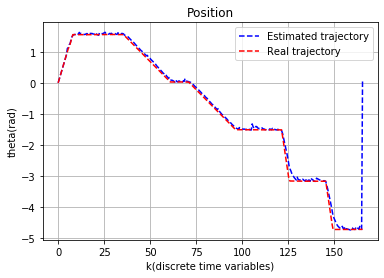

In [23]:
t = np.linspace(0,(Nsimulation-1)*dt,Nsimulation)

plt.figure(1)
plt.clf()
plt.plot(t,vec(estimated_X[0,:]),'b--')
plt.plot(t,vec(simulated_X[0,:]),'r--')
plt.title("Position")
plt.xlabel('k(discrete time variables)')
plt.ylabel('x(m)')
plt.legend(['Estimated trajectory','Real trajectory'])
plt.grid()

plt.figure(2)
plt.clf()
plt.plot(t,vec(estimated_X[1,:]),'b--')
plt.plot(t,vec(simulated_X[1,:]),'r--')
plt.title("Position")
plt.xlabel('k(discrete time variables)')
plt.ylabel('y(m)')
plt.legend(['Estimated trajectory','Real trajectory'])
plt.grid()

plt.figure(3)
plt.clf()
plt.plot(t,vec(estimated_X[2,:]),'b--')
plt.plot(t,vec(simulated_X[2,:]),'r--')
plt.title("Position")
plt.xlabel('k(discrete time variables)')
plt.ylabel('theta(rad)')
plt.legend(['Estimated trajectory','Real trajectory'])
plt.grid()


plt.figure(4)
plt.clf()
plt.plot(t,vec(estimated_X[0,:]-simulated_X[0,:]),'b--')
plt.title("error")
plt.xlabel('k(discrete time variables)')
plt.legend(['Error between estimated and real position'])
plt.grid()

plt.show()

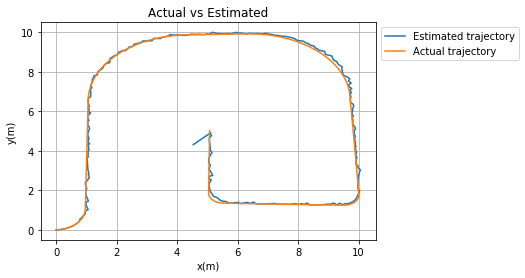

In [24]:
plt.plot(vec(estimated_X[0,:]),vec(estimated_X[1,:]))
plt.plot(vec(simulated_X[0,:]),vec(simulated_X[1,:]))
plt.title("Actual vs Estimated")
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend(['Estimated trajectory','Actual trajectory'],bbox_to_anchor=(1,1))
plt.grid()
#plt.plot(df_actual[:,0],df_actual[:,1])

In [ ]:
simulated_Y[:,328:332].T

In [ ]:
df_input[320:332,:]